# Supernova Model Fitting
In this notebook, we fit SN models to synthetic supernovae.

In [1]:
%load_ext autoreload
%autoreload 2

from lightkurve import KeplerTargetPixelFile
import numpy as np
import matplotlib.pyplot as plt
#import sncosmo
%matplotlib inline
from lightkurve.injection import SupernovaModel

tpf = KeplerTargetPixelFile.from_archive(220381074) 

lc = tpf.to_lightcurve(aperture_mask='all') 
lc = lc.remove_nans().remove_outliers() 
lc.plot(normalize=False)

In [125]:
import lightkurve.injection as inj

We are injecting a supernova into this light curve.

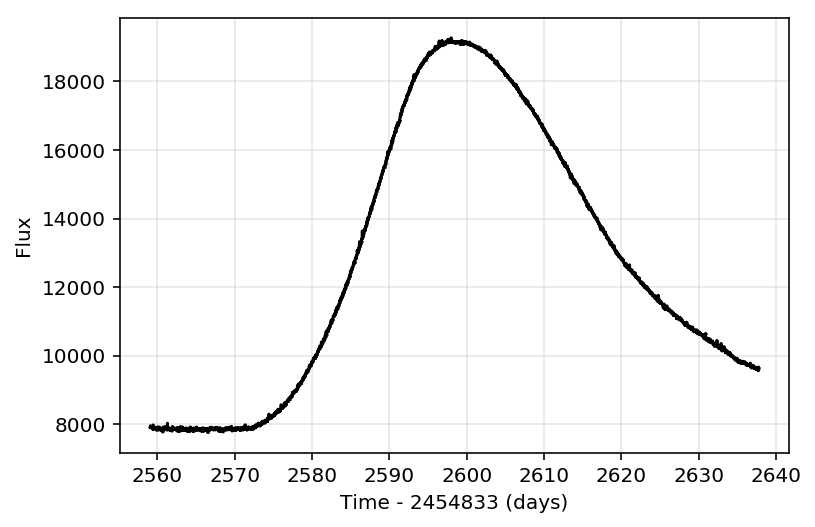

In [126]:
model = inj.SupernovaModel(T0=2600, source='hsiao', bandpass='kepler', z=0.5, amplitude=7e-7)
lcinj = inj.inject(lc, model)
#lcinj.flux = draw random values to sn model
lcinj = lcinj.remove_nans()
lcinj.plot(normalize=False)

Likelihood:  
$p(y\mid\theta)$

Prior:  
$p(\theta)$

Posterior Probability Density Distribution Function (PDF):  
$p(\theta\mid y) \propto p(y\mid\theta) \cdot p(\theta)$

For MCMC sampling, we will directly compute the posterior PDF. For optimization, we will *merely* find the maximum likelihood - in other words, the single value for $\theta$ (eg. $m, b$) that maximizes the likelihood function.  The convention in optimization is to seek the minimum value of the input function.  Accordingly, we must multiply the likelihood function by -1 so that the maximum likelihood corresponds to the minimum.

We want to compute the maximum a posteriori estimation, $\hat\theta_{map}$.


In [127]:
#wavelength = np.array([500., 10000., 19500., 29000., 38500., 48000.])
#transmission = np.array([0., 1., 1., 1., 1., 0.])
#all_band = sncosmo.Bandpass(wavelength, transmission, name='all')

def ln_like(theta):
    T0, z, amplitude, background = theta
    if (z < 0) or (z > 1) or (T0 < np.min(lc.time)) or (T0 > np.max(lc.time)):
        return -1.e99
    model = SupernovaModel(T0, z=z, amplitude=amplitude, bandpass='kepler')
    model = model.evaluate(lcinj.time) + background
    inv_sigma2 = 1.0/(lcinj.flux_err**2)
    chisq = (np.sum((lcinj.flux-model)**2*inv_sigma2))
    lnlikelihood = -0.5*chisq
    return lnlikelihood


In [128]:
def neg_ln_like(theta):
    return -1 * ln_like(theta)

In [129]:
def lnprior(theta):
    T0, z, amplitude, background = theta
    if z < 0 or z > 1:
        return -np.inf
    return 0.0

Optimization can't handle infinity values, so we redefine a lnprior that returns very large numbers instead of infinity.

In [130]:
def lnprob(theta):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + ln_like(theta)

In [131]:
def lnprior_optimization(theta):
    T0, z, amplitude, background = theta
    if (z < 0) or (z > 1):
        return -1.e99
    return 0.0

In [132]:
def ln_posterior(theta):
    lp = lnprior(theta)
    return lp + ln_like(theta)

In [133]:
def neg_ln_posterior(theta):
    log_posterior = lnprior_optimization(theta) + ln_like(theta)
    return -1 * log_posterior

In [134]:
def neg_ln_posterior_mcmc(theta):
    log_posterior = lnprior(theta) + ln_like(theta)
    return -1 * log_posterior

Run the optimization:

In [135]:
import scipy.optimize as op

In [137]:
%%time
#Injected values: T0=2600, z=0.5, amplitude=5e-8
x0 = [2610, 0.5, 3.0e-8, np.percentile(lc.flux, 3)]

result = op.minimize(neg_ln_posterior, x0)

CPU times: user 1min 43s, sys: 10.3 s, total: 1min 53s
Wall time: 1min


In [138]:
print(result)
T0_f, z_f, amplitude_f, background_f = result["x"]

      fun: 250612.2071986899
 hess_inv: array([[ 5.61101803e-07,  4.04873768e-08,  5.07559701e-16,
        -1.56816558e-05],
       [ 4.04873768e-08,  5.18815200e-09,  3.52170607e-16,
        -5.81231808e-06],
       [ 5.07559703e-16,  3.52170607e-16,  8.84175776e-22,
        -6.04239229e-12],
       [-1.56816558e-05, -5.81231808e-06, -6.04239228e-12,
         6.67945166e-02]])
      jac: array([-3.03443359e+02,  6.49335547e+03,  1.83492032e+10,  1.45898438e+00])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 525
      nit: 13
     njev: 85
   status: 2
  success: False
        x: array([2.59987935e+03, 4.81180829e-01, 6.80474238e-07, 8.01913035e+03])


Interesting, it returned new values but warns of precision loss.  The MAP parameters seem to be close to the input values.  Let's overplot the model and data to see how they compare.

In [139]:
T0_f, z_f, amplitude_f, background_f
new_model = inj.SupernovaModel(T0=T0_f, source='hsiao', bandpass='kepler', z=z_f, amplitude=amplitude_f)
byeye_model = inj.SupernovaModel(T0=2610, source='hsiao', bandpass='kepler', z=1, amplitude=5.0e-8)
new_fit = new_model.evaluate(lc.time) + background_f
byeye_fit = byeye_model.evaluate(lc.time) + 7800

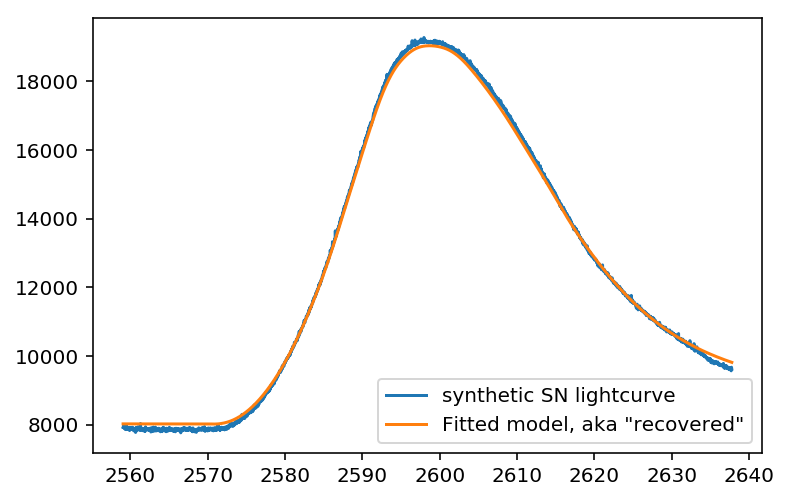

In [140]:
plt.plot(lcinj.time, lcinj.flux, label='synthetic SN lightcurve')
plt.plot(lcinj.time, new_fit, label = 'Fitted model, aka "recovered"')
#plt.plot(lcinj.time, byeye_fit, label = 'By eye fit')
plt.legend()

Hmm, suspicious-- the optimization "worked" but returned the input values.  How can this be?  Let's debug by plotting "chi-sq contours".  We'll see if a minus sign is wrong somewhere.

In [142]:
amp_arr = np.logspace(1.0e-10, 1.0e-6, 50)

In [143]:
2610, 0.5, 3.0e-8, np.percentile(lc.flux, 3)

(2610, 0.5, 3e-08, 7789.7870898437495)

In [144]:
chisqs = amp_arr*0.0
for i, amp in enumerate(amp_arr):
    chisq = neg_ln_posterior([2610, 0.5, amp, 7800])
    chisqs[i] = chisq

In [145]:
chisqs

array([1.40038871e+21, 1.40038884e+21, 1.40038897e+21, 1.40038911e+21,
       1.40038924e+21, 1.40038937e+21, 1.40038950e+21, 1.40038963e+21,
       1.40038976e+21, 1.40038990e+21, 1.40039003e+21, 1.40039016e+21,
       1.40039029e+21, 1.40039042e+21, 1.40039055e+21, 1.40039069e+21,
       1.40039082e+21, 1.40039095e+21, 1.40039108e+21, 1.40039121e+21,
       1.40039134e+21, 1.40039148e+21, 1.40039161e+21, 1.40039174e+21,
       1.40039187e+21, 1.40039200e+21, 1.40039213e+21, 1.40039226e+21,
       1.40039240e+21, 1.40039253e+21, 1.40039266e+21, 1.40039279e+21,
       1.40039292e+21, 1.40039305e+21, 1.40039319e+21, 1.40039332e+21,
       1.40039345e+21, 1.40039358e+21, 1.40039371e+21, 1.40039384e+21,
       1.40039398e+21, 1.40039411e+21, 1.40039424e+21, 1.40039437e+21,
       1.40039450e+21, 1.40039463e+21, 1.40039477e+21, 1.40039490e+21,
       1.40039503e+21, 1.40039516e+21])

In [146]:
print(result.x)

[2.59987935e+03 4.81180829e-01 6.80474238e-07 8.01913035e+03]


In [78]:
#wavelength = np.array([500., 10000., 19500., 29000., 38500., 48000.])
#transmission = np.array([0., 1., 1., 1., 1., 0.])
#all_band = sncosmo.Bandpass(wavelength, transmission, name='all')

In [118]:
#wavelength = np.array([500., 10000., 19500., 29000., 38500., 48000.])
#transmission = np.array([0., 1., 1., 1., 1., 0.])
#all_band = sncosmo.Bandpass(wavelength, transmission, name='all')

def ln_like(theta):
    T0 = theta
    if (T0 < np.min(lc.time)) or (T0 > np.max(lc.time)):
        return -np.inf
    model = SupernovaModel(T0, z=0.5, amplitude=7.e-7, bandpass='kepler')
    model = model.evaluate(lcinj.time) + 7800
    inv_sigma2 = 1.0/(lcinj.flux_err**2)
    chisq = (np.sum((lcinj.flux-model)**2*inv_sigma2))
    lnlikelihood = -0.5*chisq
    return lnlikelihood


In [119]:
count = 0

def lnprior(theta):
    global count
    T0 = theta
    if np.min(lc.time)<T0<np.max(lc.time):
        count += 1
        print(count)
        return 0.0
    return -np.inf

In [120]:
def lnprob(theta):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + ln_like(theta)

In [161]:
ndim, nwalkers = 4, 10
pos = [[2590, 0.4, 6.e-7, 7800] for i in range(nwalkers)]

In [162]:
import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, neg_ln_posterior)


In [163]:
%%time
mcmc_result = sampler.run_mcmc(pos, 25)

CPU times: user 51.3 s, sys: 5.06 s, total: 56.3 s
Wall time: 29.2 s


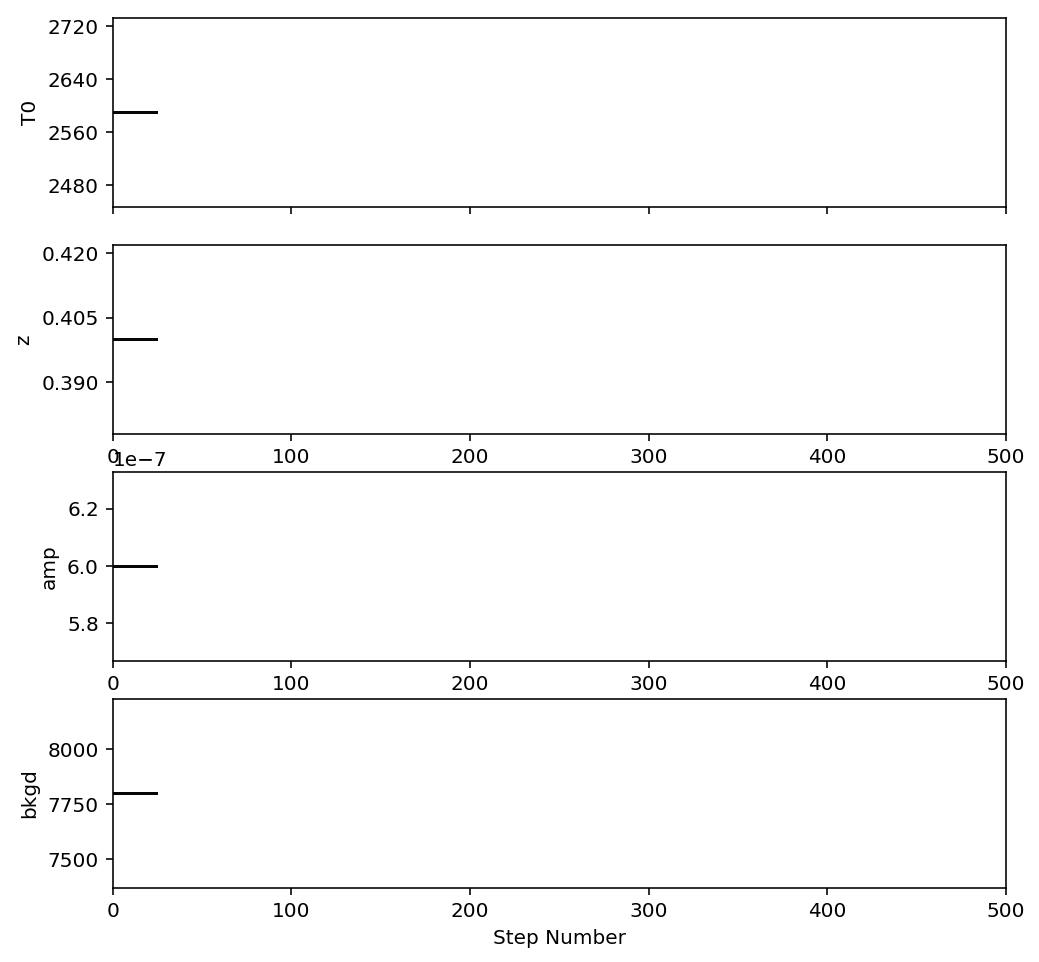

In [164]:
from matplotlib.ticker import MaxNLocator

samples = sampler.chain
labels = ['T0', 'z', 'amp', 'bkgd']

fig1 = plt.figure(figsize=[8, 8])
for i in range(samples.shape[-1]):
    ax = fig1.add_subplot(4, 1, i + 1)
    ax.plot(sampler.chain[:, 0:1000, i].T, "k", alpha=0.3)
    ax.set_xlim(0, sampler.chain.shape[1])
    if i < 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("Step Number")
    ax.set_ylabel(labels[i])
    ax.yaxis.set_major_locator(MaxNLocator(4))

    plt.xlim(0, 500)
fig1.show()

In [224]:
clean_samples = samples[:, 100:, :]
samples.shape
np.median(clean_samples, axis=(0, 1))
flat_chain = clean_samples.reshape((-1, ndim))
flat_chain.shape

(40000, 4)

IndexError: list index out of range

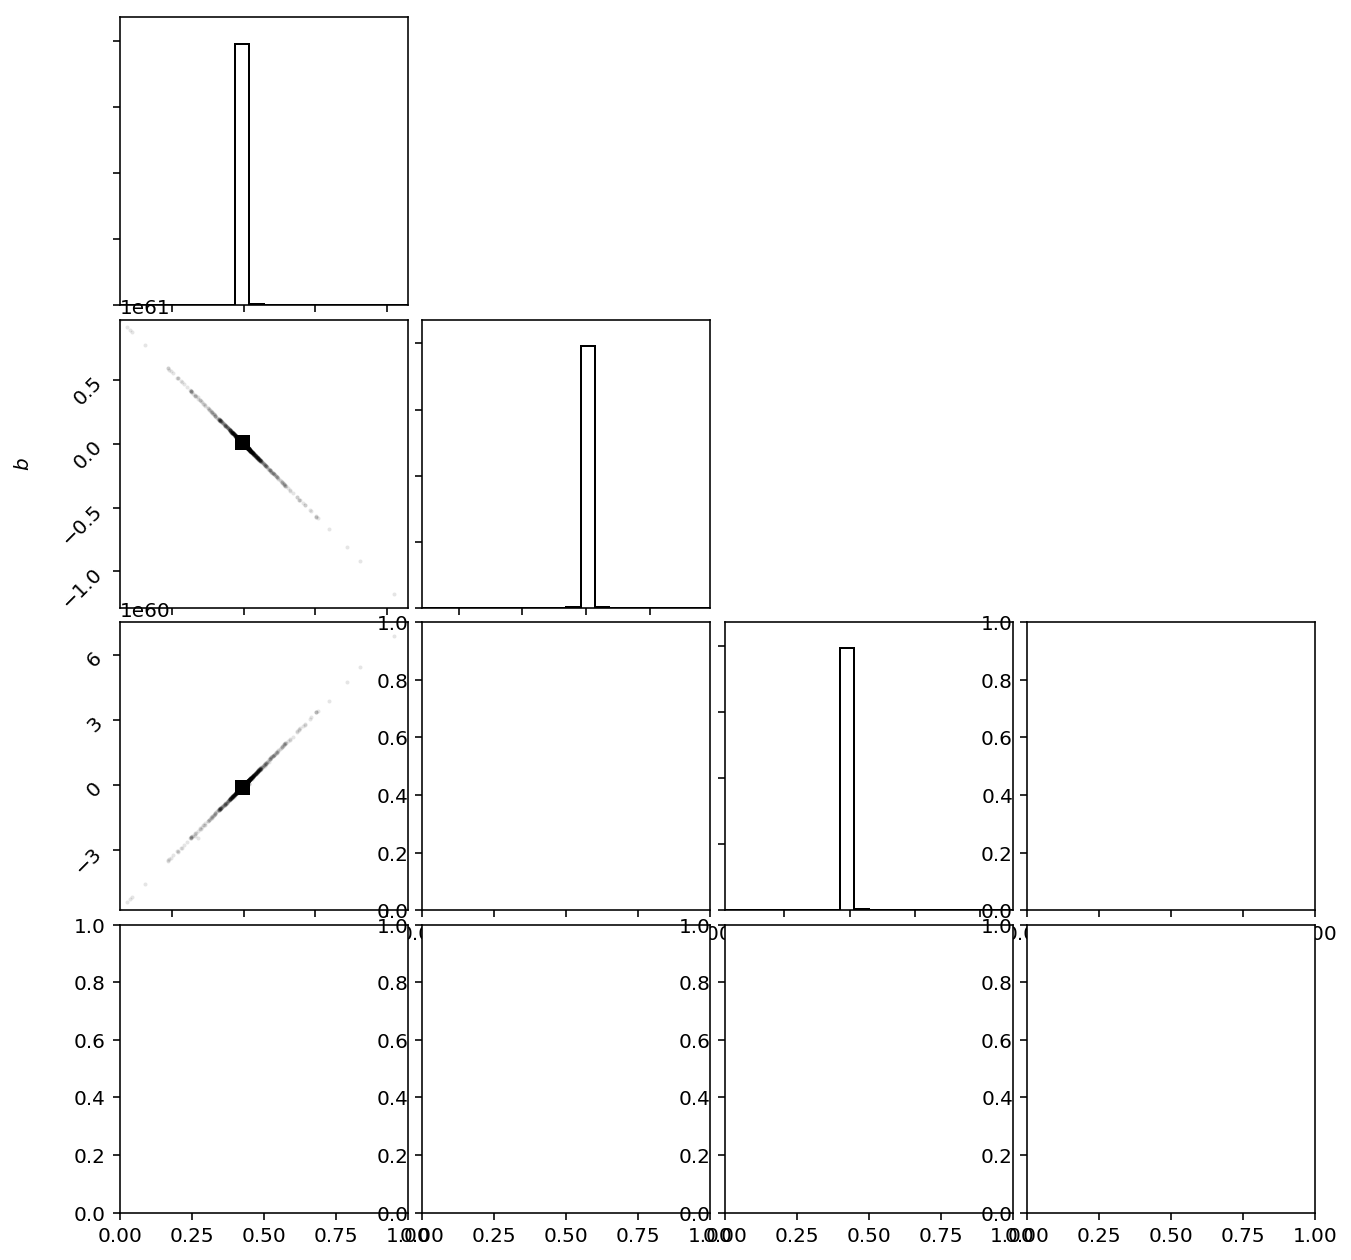

In [226]:
import corner
fig = corner.corner(flat_chain, labels=["$m$", "$b$"])

In [ ]:
lcinj.recover(method='optimize')